In [1]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
from skimage.io import imread
import cv2
import numpy as np
import os
from PIL import Image
from io import BytesIO
import time
import datetime
import h5py
from random import shuffle
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import zipfile
np.random.seed(12)
import warnings
warnings.filterwarnings('ignore')

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)
'''
TPU = True
if TPU: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
'''

REPLICAS:  1


'\nTPU = True\nif TPU: \n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

In [3]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.0


In [4]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [5]:
IMG_SIZE = 128

CHANNELS = 3

NUM_CLASSES = 2

IMG_PER_FILE = 10

epochs = 100

#kernel_regularizer = regularizers.l2(0.0001)

In [6]:
def label_video_names(VideoDataDir, from_part, end_part):
    
  # list containing video names
    names = []
  # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []

    CLASSES = ["NonViolence", "Violence"]

    for category in os.listdir(VideoDataDir):
        path = os.path.join(VideoDataDir, category)
        class_num = CLASSES.index(category)
        for i, video in enumerate(os.listdir(path)[from_part:end_part]):
            names.append(video)
            labels.append(class_num)

  #labels = np.stack((np.array(labels), np.array(labels)[::-1]), # rev axis=1)
    c = list(zip(names,labels))

  # Get a part of data

  # Suffle the data (names and labels)
    shuffle(c)
    names, labels = zip(*c)   
    return names, labels

In [7]:
def video_reader(cv2, filename):
    frames = np.zeros((IMG_PER_FILE, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float16)

    i=0
    #print(frames.shape)
    vc = cv2.VideoCapture(filename)

    #print("reading video")
    while i < IMG_PER_FILE:
        success, frame = vc.read()
        #if success:
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frm = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))

        frm = np.expand_dims(frm, axis=0)

        # rescale [0,1]
        frm = frm / 255.0

        frames[i][:] = frm
        i +=1
    
    datav = np.zeros((1, 10, IMG_SIZE, IMG_SIZE, 3), dtype=np.float16)
    datav[0][:][:] = frames
    return datav

In [8]:
def handle_exception_video(video):
    video_err = {'NV_940.mp4':'NV_939.mp4'}
    #video = 
    if video in video_err:
        return video_err[video]
    else:
        return video
    

In [9]:
def processing_data(_from, _to):
    PROJECT_DIR = '../input/real-life-violence-situations-dataset'

    VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
    # print('we have \n{} Violence videos \n{} NonViolence videos'.format(len(os.listdir(VideoDataDir + '/Violence')), len(os.listdir(VideoDataDir + '/NonViolence'))))
    # preprocess name video and labels 

    video_names, labels = label_video_names(VideoDataDir, _from, _to)

    X_original = []
    y_original = []

   #print('holdout 500 videos out of 2000, because of memory issue')
    CLASSES = ["NonViolence", "Violence"]
   #500 <- 250 + 250

    for video, label in zip(video_names, labels):
        path = os.path.join(VideoDataDir, CLASSES[label])
        
        #print((os.path.exists(path)))
        n_video = handle_exception_video(video)
        
        #print(n_video, end =" ")
        # join final video path
        video_path = os.path.join(path, n_video)
        # read_frame from video
        frames = video_reader(cv2, video_path)
        
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(label)
    
    X_original = np.array(X_original)
    y_original = np.array(y_original)
    
    y_original = to_categorical(y_original, num_classes=2)
    
    
    train_index = int(len(X_original) * 0.8)
    test_index = int(len(y_original) * 0.8)
    X_train, X_val = X_original[:train_index], X_original[test_index:]
    y_train, y_val = y_original[:train_index], y_original[test_index:]
    #X_train = X_train.reshape(-1, 30, IMG_SIZE, IMG_SIZE, 3) / 255
    #X_val = X_val.reshape(-1, 30, IMG_SIZE, IMG_SIZE, 3) / 255
    
    return X_train, X_val, y_train, y_val

In [10]:
%%time
from tqdm import tqdm
X_train, X_val, y_train, y_val = processing_data(0, 650)

CPU times: user 1min 6s, sys: 15.8 s, total: 1min 22s
Wall time: 48.3 s


In [11]:
def my_model(tf):

    # SEED
    np.random.seed(101)

    # LAYER
    layers = tf.keras.layers
    models = tf.keras.models
    losses = tf.keras.losses
    optimizers = tf.keras.optimizers
    metrics = tf.keras.metrics
    
    cnn = models.Sequential()
    
    input_shapes=(IMG_SIZE, IMG_SIZE, CHANNELS)

    VGG19_MODEL = tf.keras.applications.vgg19.VGG19

    base_model = VGG19_MODEL(include_top=False, weights='imagenet', input_shape=input_shapes)
    # Freeze the layers except the last 4 layers (we will only use the base model to extract features)
    cnn = models.Sequential()
    cnn.add(base_model)
    cnn.add(layers.Flatten())
    model = models.Sequential()
    # add cnn model
    model.add(layers.TimeDistributed(cnn, input_shape=(IMG_PER_FILE, IMG_SIZE, IMG_SIZE, CHANNELS)))
    model.add(layers.LSTM(IMG_PER_FILE , return_sequences= True))
    model.add(layers.TimeDistributed(layers.Dense(90))) 
    ## Full-connected layers
    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(NUM_CLASSES, activation="sigmoid"))
    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #model.load_weights(wgts)
    rms = optimizers.RMSprop()
    model.compile(loss="binary_crossentropy",
                    optimizer=adam,
                    metrics=["accuracy"])
    return model

In [12]:
# Create a MirroredStrategy.
if (tpu is False):
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = my_model(tf)

80134624/80134624 [==============================] - 3s 0us/step


In [13]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 8192)          20024384  
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 10, 10)            328120    
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 90)            990       
 stributed)                                                      
                                                                 
 dropout (Dropout)           (None, 10, 90)            0         
                                                                 
 global_average_pooling1d (  (None, 90)                0         
 GlobalAveragePooling1D)                                         
                                                      

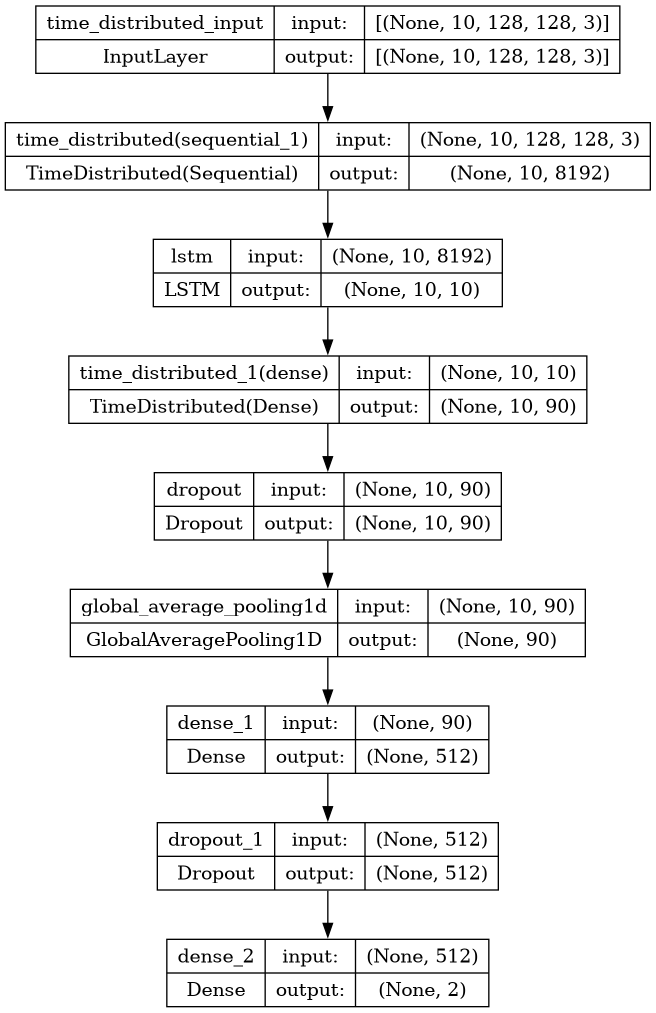

In [14]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [15]:
patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 8

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [16]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')



checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]


In [17]:
print('Training head...')


history = model.fit(X_train ,y_train, epochs=epochs, 
                    callbacks=callbacks, 
                    validation_data = (X_val, y_val),
                    batch_size=batch_size)

print('\nRestoring best Weights for CNN+LSTM')


Training head...
Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5577
Epoch 1: val_loss improved from inf to 0.67749, saving model to ModelWeights.h5
130/130 [==============================] - 46s 243ms/step - loss: 0.6884 - accuracy: 0.5577 - val_loss: 0.6775 - val_accuracy: 0.6462 - lr: 1.0000e-05
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 0.6597 - accuracy: 0.6596
Epoch 2: val_loss improved from 0.67749 to 0.59221, saving model to ModelWeights.h5
130/130 [==============================] - 29s 220ms/step - loss: 0.6597 - accuracy: 0.6596 - val_loss: 0.5922 - val_accuracy: 0.7500 - lr: 1.8000e-05
Epoch 3/100
130/130 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.6798
Epoch 3: val_loss did not improve from 0.59221
130/130 [==============================] - 28s 219ms/step - loss: 0.6218 - accuracy: 0.6798 - val_loss: 0.6237 - val_accuracy: 0.7308 - lr: 2.6000e-05
Epoch 4/100
130/130 [=======

## Validate training performance 

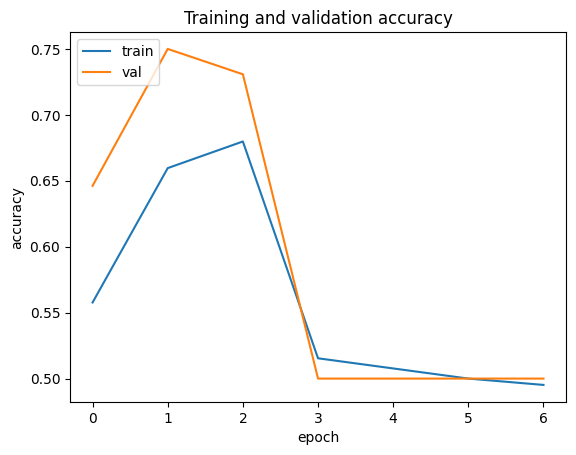

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

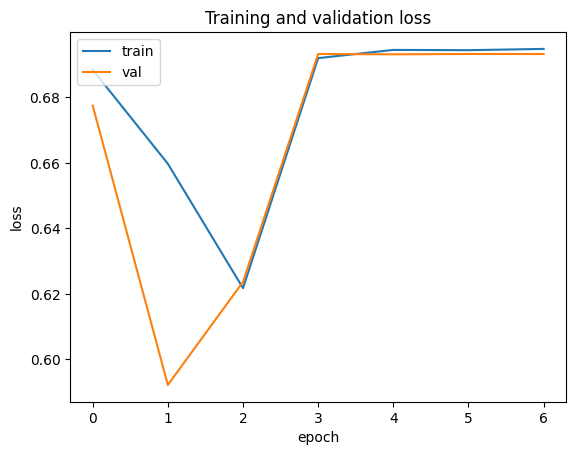

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Prediction helper

In [20]:
def pred_fight(model,video,acuracy=0.6):
    pred_test = model.predict(video)
    if pred_test[0][1] >=acuracy:
        return True , pred_test[0][1]
    else:
        return False , pred_test[0][1]

In [21]:
def main_fight(video):
    vid = video_reader(cv2,video)
    millis = int(round(time.time() * 1000))
    #print(millis)
    f , precent = pred_fight(model, vid, acuracy=0.65)
    millis2 = int(round(time.time() * 1000))
    #print(millis2)
    res_fight = {'violence':f ,'violence estimation':str(precent)} 
    res_fight['processing_time'] =  str(millis2-millis)
    return res_fight

In [22]:
"""timer_pred = [] 
res = []
for i in range(800, 810):
    path = f"../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_{i}.mp4" 
    pred = main_fight(path)
    res.append(pred['violence estimation'])
    timer_pred.append(pred['processing_time'])"""

'timer_pred = [] \nres = []\nfor i in range(800, 810):\n    path = f"../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_{i}.mp4" \n    pred = main_fight(path)\n    res.append(pred[\'violence estimation\'])\n    timer_pred.append(pred[\'processing_time\'])'

In [23]:
#res

In [24]:
#timer_pred

## TEST

In [25]:
X_t, _, y_t, _ = processing_data(800, 1000)

In [26]:
def predictor(preds):
    return round(preds[0])

In [27]:
model.load_weights('ModelWeights.h5')
predictions = model.predict(X_t)

10/10 [==============================] - 9s 211ms/step


In [28]:
preds = np.apply_along_axis(predictor, 1, predictions)
truth = np.apply_along_axis(predictor, 1, y_t)

In [29]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate the confusion matrix
corr_pred = metrics.confusion_matrix(truth, preds)

# Calculate the number of correct and wrong predictions
n_correct = int(corr_pred[0][0] + corr_pred[1][1])
n_wrongs = int(corr_pred[0][1] + corr_pred[1][0])

print('> Correct Predictions:', n_correct)
print('> Wrong Predictions:', n_wrongs)

# Print the classification report
report = metrics.classification_report(truth, preds, target_names=["NonViolence", "Violence"])
print(report)


> Correct Predictions: 230
> Wrong Predictions: 90
              precision    recall  f1-score   support

 NonViolence       0.88      0.52      0.65       163
    Violence       0.65      0.92      0.76       157

    accuracy                           0.72       320
   macro avg       0.76      0.72      0.71       320
weighted avg       0.77      0.72      0.71       320



In [30]:
corr_pred = np.array([[143,18],[15,144]])

> Correct Predictions: 287
> Wrong Predictions: 33


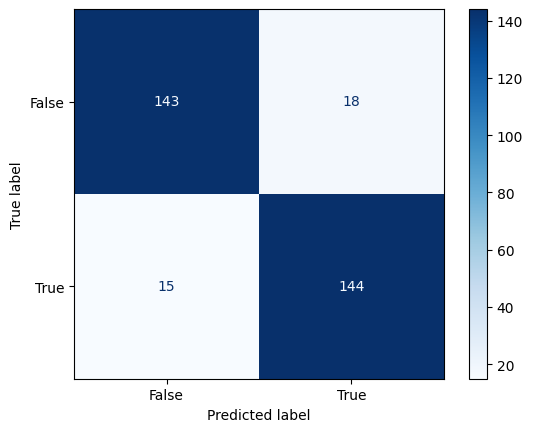

In [31]:
from sklearn import metrics

#confusion_matrix = metrics.confusion_matrix(truth, preds)
n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = corr_pred, display_labels = [False, True])
cm_display.plot(cmap=plt.cm.Blues)
#cm_display.plot()
plt.show()

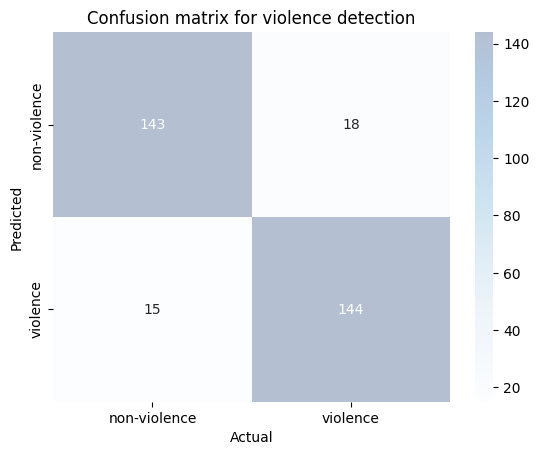

In [32]:
import pandas as pd
conf_df = pd.DataFrame(corr_pred, index=['non-violence', 'violence'], 
                       columns=['non-violence', 'violence'])

sns.heatmap(conf_df,annot=True, fmt="d",cmap="Blues", alpha=0.3)

plt.title('Confusion matrix for violence detection') # title with fontsize 20
plt.xlabel('Actual') # x-axis label with fontsize 15
plt.ylabel('Predicted') # y-axis label with fontsize 15
plt.show()

In [33]:
validation_steps = 20

print("Evaluate on test data")

results = model.evaluate(x=X_t, y=y_t, steps =validation_steps)
print("test loss, test acc:", results)



Evaluate on test data
20/20 [==============================] - 6s 122ms/step - loss: 0.6140 - accuracy: 0.7281
test loss, test acc: [0.6139832139015198, 0.7281249761581421]


In [34]:
model.save('model.h5')

In [35]:
from IPython.display import FileLink
FileLink('model.h5')

/kaggle/working/model.h5

In [36]:
def preprocess_frames(frames, input_size):
    preprocessed_frames = []

    for frame in frames:
        # Resize the frame to match the input size
        frame = cv2.resize(frame, input_size)
        
        # Normalize the pixel values to be in the range [0, 1]
        frame = frame / 255.0
        
        preprocessed_frames.append(frame)

    return preprocessed_frames

In [37]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained CNN+LSTM model
model = load_model('model.h5')  # Update with your model path

# Define parameters for video input
video_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_112.mp4'  # Update with the path to your random video
num_frames = 10  # Number of frames to process
frame_shape = (224, 224, 3)  # Match this with the input shape of your model

# Initialize a list to store preprocessed frames
frames = []

# Open the video
cap = cv2.VideoCapture(video_path)

# Read frames from the video
for _ in range(num_frames):
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame (resize to match model input size)
    frame = cv2.resize(frame, frame_shape[:-1])
    frames.append(frame)

# Preprocess the frames to match the input requirements of your model
preprocessed_frames = preprocess_frames(frames,(128,128))  # Implement your own preprocessing function

# Convert the frames to an array
input_data = np.array(preprocessed_frames)[np.newaxis, ...]  # Add a batch dimension

# Perform the prediction
predictions = model.predict(input_data)

# Interpret the predictions (you may have a threshold for classification)
predicted_class = np.argmax(predictions)
if predicted_class == 1:
    prediction_label = "Violence"
else:
    prediction_label = "Non-Violence"

print(f"Prediction: {prediction_label}")


1/1 [==============================] - 1s 1s/step
Prediction: Non-Violence
